### installations


```bash
conda install -c conda-forge emoji -y
```

```python
import nltk
nltk.download('wordnet')
nltk.download('vader_lexicon')
```

#### plotting resources

- https://towardsdatascience.com/how-i-got-matplotlib-to-plot-apple-color-emojis-c983767b39e0

In [6]:
running_in_drive = False

In [2]:
ls ../../data/original

anxiety_submissions.csv  anxiety_writing.csv      writing_submissions.csv


In [2]:
ls ../data/clean

anx_clean.csv         anxiety_writing.csv
anx_writing.csv       writing_cleaning.csv


In [16]:
# imports
import pandas as pd
import numpy as np
import regex as re
import sys
from pprint import pprint
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
%matplotlib inline

from sklearn.compose import make_column_transformer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

plt.rc('axes', unicode_minus=False)

In [17]:
# general helpers

def save_model(mdl, models_path, mdl_name):
  """
  Saves model into a pickle
  """
  # models_path = '/content/drive/MyDrive/GA/models'
  # mdl_name = 'test'
  mdl_path = f'{models_path}/{mdl_name}.pkl'


  with open(mdl_path, 'wb') as pickle_out:
      pickle_out = pickle.dump(mdl, pickle_out)

def custom_preprocessor(text):
    """
    Taken from https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp
    """
    #lowering the text case
    text = text.lower() 
    # remove special chars
    text = re.sub("\\W"," ",text)
    return text

def get_short(text):
    """
    Extracts the short string for estimators and transformers to be used in pipes.
    """
    if text is None:
        return None
    # https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case
    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    text = pattern.sub('_', text).lower()
    return ''.join([t[0] for t in text.split('_')])


from emoji_sentiment_tools_simple import get_sentiment_score_general

class TextSentimentizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        SENT = X_.apply(lambda t: get_sentiment_score_general(t))
        d = pd.DataFrame(SENT)
        d.columns = ['SENT']
        return d
            
class NoSentimentizer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        SENT = X_.apply(lambda t: 0)
        d = pd.DataFrame(SENT)
        d.columns = ['SENT']
        return d   

In [18]:
## Helpers
import emoji
import functools
import operator
import re


from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer=SentimentIntensityAnalyzer()


def extract_emojis(s):
    """
    Extracts emojis from text.
    """
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])


def separate_emojis(em):
    """
    Separates emojis from each other.
    # https://stackoverflow.com/questions/49921720/how-to-split-emoji-from-each-other-python
    """
    em_split_emoji = emoji.get_emoji_regexp().split(em)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    return ' '.join(em_split)


def get_emoji_scores(emtext, emoji_dict): 
    items = emtext.split()

    default = {'pos': 0, 'neu': 0, 'neg': 0, 'compound': 0}
    out = {'pos': 0, 'neu': 0, 'neg': 0, 'compound': 0}
    not_found = []
    for item in items:
        values = emoji_dict.get(item, default)
        if values == default:
            if item not in not_found:  
                t = emoji.demojize(item)
                text = t.replace('_', ' ').replace(':', '')
                values = analyzer.polarity_scores(text)
                print(item, text, values['compound'])
                not_found.append(item)  
        for k in default.keys():
            out[k] +=values[k]
    return out


def get_emoji_dict():
    emojis_path = '../data/emoji_scores.csv'
    if running_in_drive:
        emojis_path = '/content/drive/MyDrive/GA/data/emoji_scores.csv'


    df = pd.read_csv(emojis_path)

    out = df[['emoji', 'neg', 'neu', 'pos', 'compound']]
    out.set_index('emoji', inplace=True)
    emoji_dict = out.to_dict(orient='index')
    return emoji_dict



def get_sentiment_score(text, emoji_dict):
    analyzer.lexicon.update(emoji_dict)
    vs = analyzer.polarity_scores(text)
    emtext = separate_emojis(extract_emojis(text))
    vs_em = get_emoji_scores(emtext, emoji_dict)
    
    for k, v in vs.items():
        vs[k] += vs_em[k]

    return vs


emoji_dict = get_emoji_dict()

get_sentiment_score('hello :) 😕 😕', emoji_dict)

{'neg': 1.202, 'neu': 0.64, 'pos': 1.158, 'compound': -0.33520000000000005}

In [33]:
class Main:
    def __init__(self, to_model=True, run_eda=True):
        self.images_path = '../../presentation/images'
        self.models_path = './Azin_models'
        self.data_path = '../../data'
        if running_in_drive:
            self.images_path = '/content/drive/MyDrive/GA/images'
            self.models_path = '/content/drive/MyDrive/GA/models'
            self.data_path = '/content/drive/MyDrive/GA/data'
        
        self.set_data_path()
        self.read_data()
        self.get_stop_words()
        self.preprocess_data()

        self.get_X_y()

        self.run_train_test_split()


        self.get_baseline_info()
        
        if run_eda:
            self.do_eda()
            self.feature_extract(transformer='CountVectorizer')
            self.feature_extract(transformer='TfidfVectorizer')


        
        if to_model:
            info_list = []
            info = self.make_model_with_sentimentizer(transformer='CountVectorizer', estimator='LogisticRegression')
            info_list.append(info)

            info = self.modeling(estimator='MultinomialNB', transformer='CountVectorizer')
            info_list.append(info)

            info = self.modeling(estimator='RandomForestClassifier', transformer='CountVectorizer')
            info_list.append(info)


            info = self.modeling(estimator='LogisticRegression', transformer='TfidfVectorizer')
            info_list.append(info)
            
            self.info_list = info_list
            
            self.info_df = pd.DataFrame(self.info_list).set_index(['Estimator', 'Transformer'])
            display(self.info_df)
            


        
    def set_data_path(self):
        #self.path = '/content/drive/MyDrive/Colab Notebooks/anxiety_writing.csv'
        self.path = f'{self.data_path}/clean/anxiety_writing.csv'
        self.sep = ','
        self.emojis_path = f'{self.data_path}/emoji_scores.csv'





        
    def read_data(self):
        self.data = pd.read_csv(self.path, sep=self.sep)
#         self.data = self.data.sample(n=1000, random_state=1)

        # What is the size of our data set?
        print('shape: ', self.data.shape)
        self.data.fillna('', inplace=True)
        display(self.data.head(1))


        df = pd.read_csv(self.emojis_path)
        self.emoji_data = df

        out = df[['emoji', 'neg', 'neu', 'pos', 'compound']]
        out.set_index('emoji', inplace=True)
        self.emoji_dict = out.to_dict(orient='index')

        display(self.emoji_data.head(1))

        
        
    def preprocess_data(self):
        """
        Preprocess the data.
        Clean the text.
        Replace characters.
        Lemmatize the sentences.
        """
        self.original_text_field = 'text'
        self.text_field = "clean_text"
        self.target_field = "label"
        self.main_target_field = "subreddit"
        # Create label column

        self.data['text'] = self.data['text'].str.lower()
        for pattern in ['&gt', '&le', '#x200b', '&amp;#x200b', r'http\S+']:
            self.data['text'] = self.data['text'].str.replace(pattern, '', regex=True)
        self.data['original_text'] = self.data['text']
        self.data['text'] = self.data['text'].apply(lambda text: separate_emojis(text))
        self.data['emojis'] = self.data['text'].apply(lambda s: separate_emojis(extract_emojis(s)))

        self.data['sentiment'] = self.data['text'].apply(lambda s: get_sentiment_score(s, self.emoji_dict)['compound'])
        #self.data['text'] = self.data['text'].apply(lambda s: emoji.demojize(s).replace(':', ' ').replace('_', ''))

        replacements = {"don't": "do not", "I've": "I have", 
                        '&amp;amp;':'&',
                        "'ve": ' have', '\n': ' ', 'poses': 'pose', 
                        "doesn't": "does not"}

        for k, v in replacements.items():
            self.data['text'] = self.data['text'].str.replace(k, v, regex=True)


        lemmatizer = WordNetLemmatizer()
        self.data['text'] = self.data['text'].apply(lambda t: ' '.join([word for word in 
                                                                        t.split(' ') if word not in self.stop_words]))
        self.data['text'] = self.data['text'].apply(lambda t: ' '.join([lemmatizer.lemmatize(word) 
                                                                        for word in t.split(' ')]))


        self.data['text'] = self.data['text'].str.replace('\d+', ' ', regex=True)

        self.data['clean_text'] = self.data['text'].str.replace('_', ' ')
        self.data['subreddit'] = self.data['subreddit'].str.title()
        self.data['label'] = self.data['subreddit'].map({'Anxiety':1, 'Writing':0})
        self.data['subreddit'] = self.data['subreddit'].map({'Anxiety':'Anxiety', 'Writing':'No Anxiety'})
        self.reverse_map = {1: 'Anxiety', 0: 'No Anxiety'}
        self.display_labels=['No Anxiety', 'Anxiety']
            
            
        self.data['Length'] = self.data['original_text'].apply(len)
        self.data['Word Count']= self.data['original_text'].apply(lambda x: len(x.split()))
        
        self.data['Title Length'] = self.data['title'].apply(len)
        self.data['Title Word Count']= self.data['title'].apply(lambda x: len(x.split()))
        
        self.data['Content Length'] = self.data['selftext'].apply(len)
        self.data['Content Word Count']= self.data['selftext'].apply(lambda x: len(x.split()))

        path_to_write = f'{self.data_path}/processed_data.csv'
        self.data.to_csv(path_to_write, index=False)
            

    def get_X_y(self):
        """
        Extract X and y
        """

        self.X = self.data[self.text_field]
        self.y = self.data[self.target_field]
        
        
    def run_train_test_split(self, random_state=42, test_size=.3):
        """
        Split the data into the training and testing sets.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, 
                                                            test_size=test_size, 
                                                            stratify=self.y, 
                                                            random_state=random_state)

        print('\nSize of X train: ', sys.getsizeof(self.X_train))

        
    def get_stop_words(self):
        """
        Get the English stope words and add more stop words to it.
        """
        words = list(CountVectorizer(stop_words='english').get_stop_words())
        

        # words.extend(['writing', 'anxiety'])
        words.extend(['www', 'https', 'like', 'just', 'day', 'week', 'time', 'month', 'year', 'ask', 'question', 'thread', 'discus', 'discussion'])
        words.extend(['doe', 'don', 'thing', 'really', 'ago', 've'])
        words.extend(['x200b'])
        self.stop_words = words
    
    
    def get_baseline_info(self):
        """
        Compute and display the baseline accuracy.
        """
        
        print(f'\nBaseline Accuracy - y: {self.y.value_counts(normalize=True)[0].round(3)}')
        print(f'\nBaseline Accuracy - y test: {self.y_test.value_counts(normalize=True)[0].round(3)}')
        
        display(self.y.value_counts())
        
        self.baseline_accuracy = self.y_test.value_counts(normalize=True)[0].round(3)
        
        
    def feature_extract(self, remove_stop_words=True, transformer='CountVectorizer', ngram_range=(1,1)):
        """
        Instantiate a CountVectorizer or TfidfVectorizer.
        Vectorize the X train and X test
        """
        if remove_stop_words:
            fe = eval(transformer)(stop_words = self.stop_words, preprocessor=custom_preprocessor, 
                                   ngram_range=ngram_range, max_df=.85)
        else:
            fe = eval(transformer)()
            
        fe.fit(self.X_train)
        X_train_tf = fe.transform(self.X_train)

            
        # Transform test
        X_test_tf = fe.transform(self.X_test)
        # cvec.vocabulary_

        self.X_train_df = pd.DataFrame(X_train_tf.todense(), columns=fe.get_feature_names())
        self.X_test_df = pd.DataFrame(X_test_tf.todense(), columns=fe.get_feature_names())

        

    def plot_distributions(self):
        """
        Plot histograms for the distributions of character length and word length
        """
        
        data = self.data
        
        data = data[data['Content Length']>0]
        fig, ax = plt.subplots(1, 2, figsize=(16, 6));
        g0 = sns.histplot(data, x='Length', hue=self.main_target_field, ax = ax[0], kde=True, legend=False, alpha=.45);
        g1 = sns.histplot(data, x='Word Count', hue=self.main_target_field, ax = ax[1], kde=True, alpha=.45);
        g0.set(title='Character Length Distributions')
        g1.set(title='Word Count Distributions')
        ax[0].set_xlim(None, 4000)
        ax[1].set_xlim(None, 600)
        ax[1].set_ylabel('');
        sns.despine(top=True);
        fig.suptitle('Title+Content', fontsize=20);
        plt.savefig(f'{self.images_path}/character_word_count_dist_title_content.png', bbox_inches='tight', dpi=300)
        
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 6));
        g0 = sns.histplot(data, x='Title Length', hue=self.main_target_field, ax = ax[0], kde=True, legend=False, alpha=.45);
        g1 = sns.histplot(data, x='Title Word Count', hue=self.main_target_field, ax = ax[1], kde=True, alpha=.45);
        g0.set(title='Character Length Distributions')
        g1.set(title='Word Count Distributions')
        ax[1].set_ylabel('');
        sns.despine(top=True);
        fig.suptitle('Title', fontsize=20);
        plt.savefig(f'{self.images_path}/character_word_count_dist_title.png', bbox_inches='tight', dpi=300)
        

        fig, ax = plt.subplots(1, 2, figsize=(16, 6));
        g0 = sns.histplot(data, x='Content Length', hue=self.main_target_field, ax = ax[0], kde=True, legend=False, alpha=.45);
        g1 = sns.histplot(data, x='Content Word Count', hue=self.main_target_field, ax = ax[1], kde=True, alpha=.45);
        g0.set(title='Character Length Distributions')
        g1.set(title='Word Count Distributions')
        ax[0].set_xlim(None, 4000)
        ax[1].set_xlim(None, 600)
        ax[1].set_ylabel('');
        sns.despine(top=True);
        fig.suptitle('Content', fontsize=20);
        plt.savefig(f'{self.images_path}/character_word_count_dist_content.png', bbox_inches='tight', dpi=300)
        
        
    def do_eda(self):
        """
        Plot Distributions, bar charts for frequently occurring words.
        """
        self.plot_distributions()
        self.get_top_occurring('CountVectorizer', count=15, ngram_range = (3,3))
        self.get_top_occurring('TfidfVectorizer', count=15, ngram_range = (3,3))
        self.get_top_occurring('CountVectorizer', count=15, ngram_range = (2,2))
        self.get_top_occurring('TfidfVectorizer', count=15, ngram_range = (2,2))
        self.get_top_occurring('CountVectorizer', count=15, ngram_range = (1,1))
        self.get_top_occurring('TfidfVectorizer', count=15, ngram_range = (1,1))
        self.get_top_occurring_separated(count=15, ngram_range = (3,3))
        self.get_top_occurring_separated(count=15, ngram_range = (2,2))
        self.get_top_occurring_separated(count=15, ngram_range = (1,1))
        self.get_hashtags_separated(count=10)
        self.get_emojis_separated(count=10)
        
    def get_hashtags_separated(self, count=10):
        """
        Extract the hashtags for each subreddit.
        """
        data0 = self.data[self.data[self.target_field]==0]
        data1 = self.data[self.data[self.target_field]==1]
        
        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=(1,1), token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')

        vect_df0 = pd.DataFrame(cv.fit_transform(data0['original_text']).todense(), columns = cv.get_feature_names())
        vect_df1 = pd.DataFrame(cv.fit_transform(data1['original_text']).todense(), columns = cv.get_feature_names())
        
        self.one_gram_features_0 = vect_df0.columns.tolist()
        self.one_gram_features_1 = vect_df1.columns.tolist()

        self.hashtags0 = pd.DataFrame(vect_df0.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        self.hashtags1 = pd.DataFrame(vect_df1.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        

        self.hashtags0.index.name = 'word'
        self.hashtags0.reset_index(inplace=True)
        self.hashtags1.index.name = 'word'
        self.hashtags1.reset_index(inplace=True)
        
        self.hashtags0 = self.hashtags0[self.hashtags0['word'].str.startswith('#')]
        self.hashtags1 = self.hashtags1[self.hashtags1['word'].str.startswith('#')]
        
        self.hashtags_0 = [x for x in self.one_gram_features_0 if x.startswith('#')]
        self.hashtags_1 = [x for x in self.one_gram_features_1 if x.startswith('#')]
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        g = sns.barplot(data=self.hashtags0.head(count), y='word', x='count', ax=ax[0], 
                        edgecolor=sns.color_palette("flare", 10),
                        facecolor=(0, 0, 0, 0));
        g.set_title(f'{self.reverse_map[0]}');
        g = sns.barplot(data=self.hashtags1.head(count), y='word', x='count', ax=ax[1], 
                        edgecolor=sns.color_palette("crest", count),
                        facecolor=(0, 0, 0, 0));
        ax[1].set_ylabel('');
        ax[0].set_ylabel('');
        ax[0].set_xlabel('');
        ax[1].set_xlabel('');
        g.set_title(f'{self.reverse_map[1]}');
        sns.despine(top=True);
        ax[0].tick_params(left=False, right=False, bottom=False);
        ax[1].tick_params(left=False, right=False, bottom=False);
        ax[0].tick_params(axis="y",direction="in", pad=-200)
        ax[1].tick_params(axis="y",direction="in", pad=-200)
        plt.subplots_adjust(wspace=0, hspace=0)
        display(self.hashtags0)
        display(self.hashtags1)
        plt.savefig(f'{self.images_path}/hashtags.png', bbox_inches='tight', dpi=300)

        
    def get_emojis_separated(self, count=10):
        """
        Extract the hashtags for each subreddit.
        """
        data0 = self.data[self.data[self.target_field]==0]
        data1 = self.data[self.data[self.target_field]==1]
        
        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=(1,1), analyzer = 'char', binary = True)

        vect_df0 = pd.DataFrame(cv.fit_transform(data0['emojis']).todense(), columns = cv.get_feature_names())
        vect_df1 = pd.DataFrame(cv.fit_transform(data1['emojis']).todense(), columns = cv.get_feature_names())
        
        self.one_gram_features_emojis_0 = vect_df0.columns.tolist()
        self.one_gram_features_emojis_1 = vect_df1.columns.tolist()

        self.emojis0 = pd.DataFrame(vect_df0.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        
        
        self.emojis1 = pd.DataFrame(vect_df1.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        

        

        self.emojis0.index.name = 'word'
        self.emojis0.reset_index(inplace=True)
        self.emojis1.index.name = 'word'
        self.emojis1.reset_index(inplace=True)
        
        self.emojis0 = self.emojis0[self.emojis0['word']!=' ']
        self.emojis1 = self.emojis1[self.emojis1['word']!=' ']

        
        
        self.emojis_0 = [x for x in self.one_gram_features_emojis_0 if x!=None ]
        self.emojis_1 = [x for x in self.one_gram_features_emojis_1 if x!=None ]
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        g = sns.barplot(data=self.emojis0.head(count), y='word', x='count', ax=ax[0], 
                        edgecolor=sns.color_palette("flare", 10),
                        facecolor=(0, 0, 0, 0));
        g.set_title(f'{self.reverse_map[0]}');
        g = sns.barplot(data=self.emojis1.head(count), y='word', x='count', ax=ax[1], 
                        edgecolor=sns.color_palette("crest", count),
                        facecolor=(0, 0, 0, 0));
        ax[1].set_ylabel('');
        ax[0].set_ylabel('');
        ax[0].set_xlabel('');
        ax[1].set_xlabel('');
        g.set_title(f'{self.reverse_map[1]}');
        sns.despine(top=True);
        ax[0].tick_params(left=False, right=False, bottom=False);
        ax[1].tick_params(left=False, right=False, bottom=False);
        ax[0].tick_params(axis="y",direction="in", pad=-200)
        ax[1].tick_params(axis="y",direction="in", pad=-200)
        plt.subplots_adjust(wspace=0, hspace=0)
        display(self.emojis0)
        display(self.emojis1)
        plt.savefig(f'{self.images_path}/emojis.png', bbox_inches='tight', dpi=300)

        
    def get_top_occurring_separated(self, count=10, ngram_range = (1,2)):
        """
        Extract the commonly occurring words for each subreddit
        """
        data0 = self.data[self.data[self.target_field]==0]
        data1 = self.data[self.data[self.target_field]==1]
        

        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=ngram_range, token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')
        
         

        vect_df0 = pd.DataFrame(cv.fit_transform(data0[self.original_text_field]).todense(), columns = cv.get_feature_names())
        vect_df1 = pd.DataFrame(cv.fit_transform(data1[self.original_text_field]).todense(), columns = cv.get_feature_names())
        


        self.top_occurring0 = pd.DataFrame(vect_df0.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        self.top_occurring1 = pd.DataFrame(vect_df1.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        self.top_occurring0.index.name = 'word'
        self.top_occurring0.reset_index(inplace=True)
        self.top_occurring1.index.name = 'word'
        self.top_occurring1.reset_index(inplace=True)
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 10))
        g = sns.barplot(data=self.top_occurring0.head(count), y='word', x='count', ax=ax[0], 
                        edgecolor=sns.color_palette("flare", 10),
                        facecolor=(0, 0, 0, 0));
        g.set_title(f'{self.reverse_map[0]}');
        g = sns.barplot(data=self.top_occurring1.head(count), y='word', x='count', ax=ax[1], 
                        edgecolor=sns.color_palette("crest", count),
                        facecolor=(0, 0, 0, 0));
        ax[1].set_ylabel('');
        ax[0].set_ylabel('');
        g.set_title(f'{self.reverse_map[1]}');
        sns.despine(top=True);
        ax[0].tick_params(left=False, right=False, bottom=False);
        ax[1].tick_params(left=False, right=False, bottom=False);
        if ngram_range[1]==3:
            pad = -240
        else:
            pad = -150
        ax[0].tick_params(axis="y",direction="in", pad=pad)
        ax[1].tick_params(axis="y",direction="in", pad=pad)
        fig.suptitle(f'{ngram_range[1]}-gram Words', fontsize=30);
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(f'{self.images_path}/top_occurring_ngram_{ngram_range[0]}_{ngram_range[1]}.png', bbox_inches='tight', dpi=300)

    def get_top_occurring(self, transformer, ngram_range=(1,2), count=20):
        """
        Get the top occurring words in all the data.
        """
        
        cv = CountVectorizer(stop_words= self.stop_words, ngram_range=ngram_range, 
                             token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+')
        
        vect_df = pd.DataFrame(cv.fit_transform(self.data[self.original_text_field]).todense(), columns = cv.get_feature_names())
        top_occurring = pd.DataFrame(vect_df.sum()
                                 .sort_values(ascending=False),
                                 columns=['count'],
                                )
        top_occurring.index.name = 'word'
        top_occurring.reset_index(inplace=True)
        self.top_occurring = top_occurring
        #display(top_occurring)
        plt.figure(figsize=(15, 10))
        g = sns.barplot(data=self.top_occurring.head(count), y='word', x='count',
                       edgecolor=sns.color_palette("colorblind", count),
                        facecolor=(0, 0, 0, 0));
        
#         fig.suptitle(f'{ngram_range[1]}-gram Words', fontsize=30);
        g.set_title(f'{ngram_range[1]}-gram Words');
        sns.despine(top=True);
        g.set_ylabel('');
        g.tick_params(left=False, right=False, bottom=False);
        if ngram_range[1]==3:
            pad = -270
        else:
            pad = -200
        g.tick_params(axis="y",direction="in", pad=pad)
        plt.savefig(f'{self.images_path}/all_top_occurring_{transformer}_ngram_{ngram_range[0]}_{ngram_range[1]}.png', 
                    bbox_inches='tight', dpi=300)
        
    def do_grid_search(self, mdl, param_grid, cv = 5, results={}):

        # Instantiate GridSearchCV.
        gs = GridSearchCV(
            # what object are we optimizing?
            estimator = mdl,
            # what parameters values are we searching?
            param_grid = param_grid,
            # 5-fold cross-validation.
            cv = cv,
            n_jobs = -1
        )

        # Fit GridSearch to training data.
        gs.fit(self.X_train, self.y_train)

        # What's the best score?
        best_score = gs.best_score_

        # What are the best hyperparameters?
        best_hyperparameters = gs.best_params_

        # Score model on training set.
        train_score = gs.score(self.X_train, self.y_train)

        # Score model on testing set.
        test_score = gs.score(self.X_test, self.y_test)


        print('\n\tGrid Search Results')
        print('\t\tBest Parameters')
        for k, v in best_hyperparameters.items():
            print(f'\t\t{k} : {v}')

        print('\n\t\tBest Score ', best_score.round(3))
        print('\t\tTrain Score: ', train_score.round(3))
        print('\t\tTest Score: ', test_score.round(3))
        
        results.update({
            'Grid Search Given Parameters': param_grid,
            'Grid Search Best Score': best_score.round(3),
            'Grid Search Train Score': train_score.round(3),
            'Grid Search Test Score': test_score.round(3),
            'Grid Search Best Hyperparameters': best_hyperparameters
            })
        return gs, results
    
    
    def make_confusion_matrix(self, mdl, results={}):
        """
        Plot the confusion matrix.
        """
        # Get predictions
        self.preds = mdl.predict(self.X_test)

        # Save confusion matrix values
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.preds).ravel()

        # View confusion matrix
        disp = plot_confusion_matrix(mdl, self.X_test, self.y_test, cmap='Blues', 
                                     values_format='d', display_labels=self.display_labels);


        # Calculate the specificity (TRUE NEG RATE)
        spec = tn/(tn + fp)

        # calculate precision
        prec = tp / (tp + fp)
        f1 = 2 * tp / (2*tp+fp+fn)
        
        sens = tp / (tp + fn)
        
        acc = (tn + tp) / (tn + fp + fn + tp)

        print('\tF1 - score: ', f1.round(3))
        print('\tRecall (Sensitivity): ', sens.round(3))
        print('\tSpecificity (True Negative Rate): ', spec.round(3))
        print('\tPrecision: ', prec.round(3))
        print('\tAccuracy: ', acc.round(3))
        results.update({
            'F1 - score': f1.round(3),
            'Recall (Sensitivity)': sens.round(3),
            'Specificity (True Negative Rate)': spec.round(3),
            'Precision': prec.round(3),
            'Accuracy': acc.round(3),
            
        })
        plt.text(3, -1.5, f'Accuracy: {acc.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, -1, f'Precision: {prec.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, -.5, f'F1 - score: {f1.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, 0, f'Recall (Sensitivity): {sens.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, .5, f'Specificity (True Negative Rate): {spec.round(2)*100:.0f}%', fontsize=20)
        
        indent = .5
        for k, v in results['Grid Search Best Hyperparameters'].items():
            indent+=.5
            plt.text(3, indent, f"{k.split('__')[1]}: {v}", fontsize=20)
        return disp, results
    
    def modeling(self, 
                 estimator='MultinomialNB',
                 transformer='CountVectorizer',
                 grid_search=True,
                 cv = 5):
        """
        Model the data with the given parameters.
        """

        # Let's set a pipeline up with two stages:
        # 1. CountVectorizer (transformer) or tf-idf vectorizer (transformer)
        # 2. Multinomial Naive Bayes (estimator)

        transformer_short = get_short(transformer)
        estimator_short = get_short(estimator)

        pipe = Pipeline([
            (transformer_short, eval(transformer)(stop_words=self.stop_words, ngram_range=(1,2))),
            (estimator_short, eval(estimator)())    
        ])

        # Estimate how your model will perform on unseen data
        cv_score = cross_val_score(pipe, self.X_train, self.y_train, cv=cv).mean()

        # Fit your model
        pipe.fit(self.X_train, self.y_train)

        # Training score
        train_score = pipe.score(self.X_train, self.y_train)
        # Test score
        test_score = pipe.score(self.X_test, self.y_test)
                        
        info = {'Transformer': transformer,
                'Estimator': estimator,
                'Basic Validation Score': cv_score.round(3),
                'Basic Train Score': train_score.round(3),
                'Basic Test Score': test_score.round(3)}
                        

        print(f'\nResults for transformer: "{transformer}" & estimator: "{estimator}"')
        print('\tValidation Score: ', cv_score.round(3))
        print('\tTrain Score: ', train_score.round(3))
        print('\tTest Score: ', test_score.round(3))

        mdl = pipe
        to_save_mdl = pipe
        

        if grid_search:
            if transformer == 'CountVectorizer':
                # Search over the following values of hyperparameters:
                # Maximum number of features fit: 2000, 3000, 4000, 5000
                # Minimum number of documents needed to include token: 2, 3
                # Maximum number of documents needed to include token: 90%, 95%
                # Check (individual tokens) and also check (individual tokens and 2-grams).

                param_grid = {
                f'{transformer_short}__min_df': [2, 3, 4],
                f'{transformer_short}__max_df': [0.92, 0.95],
                f'{transformer_short}__ngram_range': [(1,1), (1,2), (2, 3)]
                }
                
                if estimator == 'DecisionTreeClassifier':
                    param_grid.update({
                        f'{estimator_short}__max_depth': [5, 10, 20, 30],
                        f'{estimator_short}__min_samples_split': [5, 10, 15, 20, 30],
                        f'{estimator_short}__min_samples_leaf': [5, 10],
                    })
                elif estimator == 'RandomForestClassifier':
                    param_grid.update({
                        f'{estimator_short}__n_estimators': [100, 150, 200],
                        f'{estimator_short}__max_depth': [None, 1, 2, 3, 4, 5],
                        f'{estimator_short}__max_features': ['sqrt', .5]
                    })
                else:
                    param_grid.update({
                        f'{transformer_short}__max_features': [2000, 3000, 4000, 5000],
                    })
                
            elif transformer == 'TfidfVectorizer':
                # Search over the following values of hyperparameters:
                # Maximum number of features fit: 2000, 3000, 4000, 5000
                # No stop words and english stop words
                # Check (individual tokens) and also check (individual tokens and 2-grams).
                
                param_grid = {
                    f'{transformer_short}__ngram_range': [(1,1), (1,2), (1, 3)],
                    f'{transformer_short}__max_features': [500, 1000, 2000, 3000],
                }
                
                if estimator == 'DecisionTreeClassifier':
                    param_grid.update({
                        f'{estimator_short}__max_depth': [5, 10, 20, 30],
                        f'{estimator_short}__min_samples_split': [5, 10, 15, 20, 30],
                        f'{estimator_short}__min_samples_leaf': [5, 10],
                    })
                elif estimator == 'RandomForestClassifier':
                    param_grid.update({
                        'rf__n_estimators': [100],
                        'rf__max_depth': [None, 5],
#                         'rf__max_features': ['sqrt', .5]
                    })
                # else:
                #     param_grid.update({
                #         f'{transformer_short}__max_features': [2000, 3000, 4000, 5000],
                #     })
            

            gs, info = self.do_grid_search(mdl, param_grid, cv = 5, results=info)
            mdl = gs.best_estimator_ 
            to_save_mdl = gs

        self.preds = mdl.predict(self.X_test)
        feature_importances = self.get_feature_importances(mdl, transformer, estimator)
        coefficients = self.get_coefficients(mdl, transformer, estimator)
        disp, info = self.make_confusion_matrix(mdl, results=info)
        if disp is not None:
          disp.ax_.set_title(f'Confusion Matrix\nTransformer: "{transformer}"\nEstimator: "{estimator}"')
          plt.savefig(f'{self.images_path}/confusion_matrix_{transformer}_{estimator}.png', bbox_inches='tight', dpi=300)
        info.update({'mdl': mdl})
        info.update({'to_save_mdl': to_save_mdl})
        save_model(to_save_mdl, self.models_path, f'grid_{transformer}_{estimator}')
        save_model(mdl, self.models_path, f'mdl_{transformer}_{estimator}')
        return info


    def get_coefficients(self, mdl, transformer, estimator):
        print(transformer)
        print(estimator)
        """
        Extract the feature importances from the resulting model.
        """

        try:
          coefficients = mdl.named_steps[get_short(estimator)].coef_[0]
          vec = mdl.named_steps[get_short(transformer)]
          col_names = vec.get_feature_names()


          fi = pd.DataFrame(
                      pd.Series(coefficients, col_names, name='Coefficients')
                              .sort_values(ascending=False)).head(30)


          fi.index.name='Word'
          fi.reset_index(inplace=True)
          self.fi = fi
          plt.figure(figsize=(15, 10))
          g = sns.barplot(data=fi, y='Word', x='Coefficients', 
                  edgecolor=sns.color_palette("coolwarm", fi.shape[0]),
                  facecolor=(0, 0, 0, 0));
          sns.despine(top=True);
          g.set_ylabel('');
          g.tick_params(left=False, right=False, bottom=False);
          g.set_title(f'Transformer: "{transformer}"\nEstimator: "{estimator}"', fontsize = 30)
          plt.savefig(f'{self.images_path}/coefficients_{transformer}_{estimator}.png', bbox_inches='tight', dpi=300)
          return coefficients
        except Exception as e:
          print(e)
          return



    def get_important_features_mnb(self, mdl, transformer, estimator):
        print(transformer)
        print(estimator)

        if estimator != 'MultinomialNB':
          return

        """
        Extract the feature importances from the resulting model.
        """

        try:
          NB_optimal = mdl.named_steps[get_short(estimator)]
          vec = mdl.named_steps[get_short(transformer)]
          col_names = vec.get_feature_names()

          neg_class_prob_sorted = NB_optimal.feature_log_prob_[0, :].argsort()[::-1]
          pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()[::-1]

          print(np.take(col_names, neg_class_prob_sorted[:10]))
          print(np.take(col_names, pos_class_prob_sorted[:10]))

          fi_neg = pd.DataFrame(
                      pd.Series(NB_optimal.feature_log_prob_[0, :], col_names, name='Feature Log Probability')
                              .sort_values(ascending=False)).head(30)

          fi_pos = pd.DataFrame(
                      pd.Series(NB_optimal.feature_log_prob_[1, :], col_names, name='Feature Log Probability')
                              .sort_values(ascending=False)).head(30)


          fi = fi_neg
          fi.index.name='Word'
          fi.reset_index(inplace=True)
          self.fi = fi
          plt.figure(figsize=(15, 10))
          g = sns.barplot(data=fi, y='Word', x='Feature Log Probability', 
                  edgecolor=sns.color_palette("coolwarm", fi.shape[0]),
                  facecolor=(0, 0, 0, 0));
          sns.despine(top=True);
          g.set_ylabel('');
          g.tick_params(left=False, right=False, bottom=False);
          g.set_title(f'Transformer: "{transformer}"\nEstimator: "{estimator}"', fontsize = 30)
          plt.savefig(f'{self.images_path}/mnb_importance_{transformer}_{estimator}.png', bbox_inches='tight', dpi=300)
          return NB_optimal.feature_log_prob_[1, :]
        except Exception as e:
          print(e)
          return
        

    
    def get_feature_importances(self, mdl, transformer, estimator):
        print(transformer)
        print(estimator)
        """
        Extract the feature importances from the resulting model.
        """

        if estimator == 'MultinomialNB':
          return self.get_important_features_mnb(mdl, transformer, estimator)

        feature_importances = None
        try:
            mdl._final_estimator
            try:
                feature_importances = mdl._final_estimator.feature_importances_
                self.feature_extract(transformer=transformer, ngram_range=(1,1))
                vec = mdl.named_steps[get_short(transformer)]
                col_names = vec.get_feature_names()

                fi = pd.DataFrame(
                    pd.Series(feature_importances, col_names, name='Feature Importance')
                            .sort_values(ascending=False)).head(30)
                fi.index.name='Word'
                fi.reset_index(inplace=True)
                self.fi = fi
                plt.figure(figsize=(15, 10))
                g = sns.barplot(data=fi, y='Word', x='Feature Importance', 
                        edgecolor=sns.color_palette("coolwarm", fi.shape[0]),
                        facecolor=(0, 0, 0, 0));
                sns.despine(top=True);
                g.set_ylabel('');
                g.tick_params(left=False, right=False, bottom=False);
                g.set_title(f'Transformer: "{transformer}"\nEstimator: "{estimator}"', fontsize = 30)
                plt.savefig(f'{self.images_path}/feature_importance_{transformer}_{estimator}.png', bbox_inches='tight', dpi=300)
            except Exception as e:
                print(e)
        except Exception as e:
            print(e)
        return feature_importances
    


    def make_model_with_sentimentizer(self, transformer='CountVectorizer', estimator='LogisticRegression'):
        sentimentizer = 'TextSentimentizer'

        col_transformer = make_column_transformer(
             (CountVectorizer(), self.text_field),
             (TextSentimentizer(), self.text_field),
        )


        pipe = Pipeline([
            (get_short(transformer), col_transformer),
            (get_short(estimator), eval(estimator)())    
        ])


        pipe.fit(pd.DataFrame(self.X_train), self.y_train)
        train_score = pipe.score(pd.DataFrame(self.X_train), self.y_train)
        test_score = pipe.score(pd.DataFrame(self.X_test), self.y_test)
        
        info = {'Transformer': transformer,
                'Estimator': estimator,
                'Basic Train Score': train_score.round(3),
                'Basic Test Score': test_score.round(3)}

        mdl_name = f'mdl_{transformer}_{estimator}_{sentimentizer}'
        
        mdl = pipe

        save_model(mdl, self.models_path, mdl_name)
        
        disp, conf_info = self.make_confusion_matrix_alt(mdl, results=info)
        if disp is not None:
          disp.ax_.set_title(f'Confusion Matrix\nTransformer: "{transformer}"\nEstimator: "{estimator} - Sentiment"')
          plt.savefig(f'{self.images_path}/confusion_matrix_{transformer}_{estimator}_sentimentizer.png', bbox_inches='tight', dpi=300)
        
        info.update(conf_info)
        info.update({'mdl': mdl})
        return info
        
        
    def make_confusion_matrix_alt(self, mdl, results={}):
        """
        Plot the confusion matrix.
        """
        # Get predictions
        self.preds = mdl.predict(pd.DataFrame(self.X_test))

        # Save confusion matrix values
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.preds).ravel()

        # View confusion matrix
        disp = plot_confusion_matrix(mdl, pd.DataFrame(self.X_test), self.y_test, cmap='Blues', 
                                     values_format='d', display_labels=self.display_labels);


        # Calculate the specificity (TRUE NEG RATE)
        spec = tn/(tn + fp)

        # calculate precision
        prec = tp / (tp + fp)
        f1 = 2 * tp / (2*tp+fp+fn)
        
        sens = tp / (tp + fn)
        
        acc = (tn + tp) / (tn + fp + fn + tp)

        print('\tF1 - score: ', f1.round(3))
        print('\tRecall (Sensitivity): ', sens.round(3))
        print('\tSpecificity (True Negative Rate): ', spec.round(3))
        print('\tPrecision: ', prec.round(3))
        print('\tAccuracy: ', acc.round(3))
        results.update({
            'F1 - score': f1.round(3),
            'Recall (Sensitivity)': sens.round(3),
            'Specificity (True Negative Rate)': spec.round(3),
            'Precision': prec.round(3),
            'Accuracy': acc.round(3),
            
        })
        plt.text(3, -1.5, f'Accuracy: {acc.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, -1, f'Precision: {prec.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, -.5, f'F1 - score: {f1.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, 0, f'Recall (Sensitivity): {sens.round(2)*100:.0f}%', fontsize=20)
        plt.text(3, .5, f'Specificity (True Negative Rate): {spec.round(2)*100:.0f}%', fontsize=20)
        
        return disp, results

shape:  (6000, 9)


,author,link_flair_text,num_comments,selftext,title,created_utc,text,clean_text,subreddit
0,JackW357,DAE Questions,9,,Anyone else scared of dying and scared of when...,1606687976,DAE Questions Anyone else scared of dying and ...,DAE Questions Anyone else scared of dying and ...,Anxiety


,Char,Unicode,Occurrences [5-max],Position [0-1],Neg [0-1],Neut [0-1],Pos [0-1],Sentiment score [-1-+1],Sentiment bar (c.i. 95%),name,block,demojized,neg,neu,pos,emoji,compound
0,😂,0x1f602,14622,0.805,0.247,0.285,0.468,0.221,NaN,FACE WITH TEARS OF JOY,Emoticons,:face_with_tears_of_joy:,0.247,0.285,0.468,😂,0.221


🤢 nauseated face 0.0
🤪 zany face 0.0
✌🏼 victory hand medium-light skin tone 0.4939
✌🏼 victory hand medium-light skin tone 0.4939
🙄 face with rolling eyes 0.0
🥺 pleading face 0.0
🥺 pleading face 0.0
🥲 smiling face with tear 0.4588
🙃 upside-down face 0.0
🥳 partying face 0.3818
🙄 face with rolling eyes 0.0
🤗 smiling face with open hands 0.4588
🤯 exploding head 0.0
🙁 slightly frowning face -0.2748
🖤 black heart 0.0
🦀 crab 0.0
🥂 clinking glasses 0.0
✌🏼 victory hand medium-light skin tone 0.4939
🙂 slightly smiling face 0.4033
🥺 pleading face 0.0
🤡 clown face 0.0
🥺 pleading face 0.0
🙄 face with rolling eyes 0.0
✋🏾 raised hand medium-dark skin tone 0.4939
🥺 pleading face 0.0
🙂 slightly smiling face 0.4033
🥲 smiling face with tear 0.4588
💪🏻 flexed biceps light skin tone 0.0
🤢 nauseated face 0.0
🙏🏽 folded hands medium skin tone 0.0
🤦 person facepalming 0.0
♀ female sign 0.0
🤢 nauseated face 0.0
🙃 upside-down face 0.0
🥺 pleading face 0.0
🙏🏻 folded hands light skin tone 0.0
🥴 woozy face 0.0
🧠 brai

1    3000
0    3000
Name: label, dtype: int64

	F1 - score:  0.976
	Recall (Sensitivity):  0.967
	Specificity (True Negative Rate):  0.986
	Precision:  0.985
	Accuracy:  0.976


,,Basic Train Score,Basic Test Score,F1 - score,Recall (Sensitivity),Specificity (True Negative Rate),Precision,Accuracy,mdl
Estimator,Transformer,,,,,,,,
LogisticRegression,CountVectorizer,0.998,0.976,0.976,0.967,0.986,0.985,0.976,(ColumnTransformer(transformers=[('countvector...


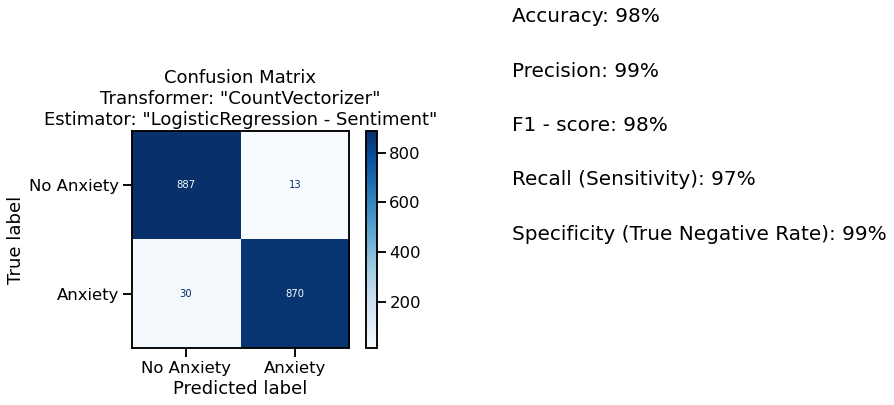

In [34]:
G = Main(to_model=True, run_eda=False)

|                                           |      Train Score |   Test Score |   F1 - score |   Recall |   Specificity |   Precision |   Accuracy |
|:------------------------------------------|--------------------------:|-------------------------:|-------------:|-----------------------:|-----------------------------------:|------------:|-----------:|
| MultinomialNB     |                       0.982 |                    0.979 |        0.979 |                  0.991 |                              0.967 |       0.967 |      0.979 |
| LogisticRegression |                        0.99  |                    0.982 |        0.982 |                  0.98  |                              0.983 |       0.983 |      0.982 |
| RandomForestClassifier|                        1.0 |                    0.977 |        0.977|                   0.978  |                             0.977 |       0.977 |     0.977|
| Logistic Regression with Sentiments| 0.998 |              0.976 |        0.976 |                  0.967 |                              0.986 |       0.985 |      0.976 |